In [1]:
### General Package
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import math

### DL packages
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations # Data augmentation Package
from albumentations.pytorch import ToTensorV2

### user-defined 
from dataset import *
from DataSummary import *
from HyperParameterTuning import *
from Model import *
from SplittingDataset import *
from TrainingProcess import *
from Utils import *
### other setups
pd.options.display.float_format ='{:.2f}'.format
%matplotlib inline

C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
#### Config
import torch
import albumentations as A
import os
from albumentations.pytorch import ToTensorV2

SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 4
BATCH_SIZE = 16 # 64
PIN_MEMORY = True
LOAD_MODEL = False
LEARNING_RATE = 1e-4
NUM_EPOCHS = 30
IMAGE_HEIGHT = 128 
IMAGE_WIDTH = 128 

original_dataset_dir = 'dataset/'
savePath = 'SaveFile/'
data_path = os.path.join(original_dataset_dir,'dataset')
datasetList =['train','valid','test']
SplittingRatio = (0.8,0.2,0)
classList = ['fields','roads']

# Data preprocessing
train_transform = A.Compose([
          A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          ### Image Augmentation
          A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Rotate(limit=35, p=1.0),
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.1),
          ###
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std = [1.0, 1.0, 1.0],
              max_pixel_value = 255.0,
          ),
          ToTensorV2(),
      ])
val_transform = A.Compose([
          A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std = [1.0, 1.0, 1.0],
              max_pixel_value = 255.0,
          ),
          ToTensorV2(),
      ])

# Main Function

In [3]:
### main.py
# Spliting Dataset
SplittingDataset(original_dataset_dir,data_path,datasetList,SplittingRatio,classList)
# Locate Train-val dir
train_root_dir = original_dataset_dir + datasetList[0]
val_root_dir = original_dataset_dir + datasetList[1]

# Data processing
train_ds = FieldRoadDataset(train_root_dir,train_transform) # 123
val_ds = FieldRoadDataset(val_root_dir,val_transform) # 30

# Batch Processing
trainLoader = DataLoader(train_ds,batch_size = BATCH_SIZE,num_workers = NUM_WORKERS,pin_memory = PIN_MEMORY,shuffle=True)
valLoader = DataLoader(val_ds,batch_size = BATCH_SIZE,num_workers = NUM_WORKERS,pin_memory = PIN_MEMORY,shuffle=True)

# Initialization
#model = MODEL().to(DEVICE)
model = pretrainedUsedMODEL().to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss() # binary cross entropy loss function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

# Load model
if LOAD_MODEL:
  if not os.path.exists(savePath):
    os.makedirs(savePath)
  load_checkpoint(torch.load(savePath+ 'my_checkpoint.pth.tar'), model)

train_acc= []
val_acc = []
train_loss = []
val_loss = []

C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\torch\cuda\amp\grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [4]:
for epoch in range(NUM_EPOCHS):
    print(f'The Epoch: {epoch}/{NUM_EPOCHS}')
    # Loss
    train_loss.append(train_fn(trainLoader, model, optimizer, loss_fn, scaler, DEVICE))
    val_loss.append(val_fn(valLoader,model,loss_fn,DEVICE))
    # Accuracy
    val_acc.append(check_accuracy(valLoader, model, DEVICE))
    train_acc.append(check_accuracy(trainLoader, model, DEVICE))
    # Save Check Point
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

The Epoch: 0/30


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:34<00:00,  4.27s/it, loss=0.481]


Got 27 / 30 with accuracy 90.00
Got 118 / 123 with accuracy 95.93
=> Saving checkpoint
The Epoch: 1/30


100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:45<00:00,  5.63s/it, loss=0.269]


Got 27 / 30 with accuracy 90.00
Got 122 / 123 with accuracy 99.19
=> Saving checkpoint
The Epoch: 2/30


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:36<00:00,  4.62s/it, loss=0.0144]


Got 26 / 30 with accuracy 86.67
Got 122 / 123 with accuracy 99.19
=> Saving checkpoint
The Epoch: 3/30


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:36<00:00,  4.50s/it, loss=0.0156]


Got 27 / 30 with accuracy 90.00
Got 121 / 123 with accuracy 98.37
=> Saving checkpoint
The Epoch: 4/30


100%|███████████████████████████████████████████████████████████████████████| 8/8 [00:42<00:00,  5.29s/it, loss=0.0011]


Got 27 / 30 with accuracy 90.00
Got 123 / 123 with accuracy 100.00
=> Saving checkpoint
The Epoch: 5/30


100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:39<00:00,  4.95s/it, loss=0.00401]


Got 27 / 30 with accuracy 90.00


KeyboardInterrupt: 

In [ ]:
name_fig = 'pretrainedUsedModel'
ResultPlot(val_acc,train_acc,train_loss,val_loss,NUM_EPOCHS,name_fig,save=True)

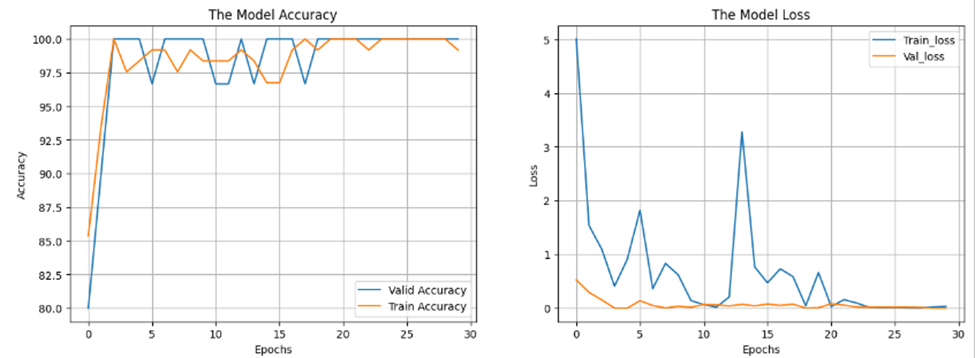

In [ ]:
# Validate in text set
# Load model
# model = pretrainedUsedMODEL().to(DEVICE)
# load_checkpoint('my_checkpoint.pth.tar',model)
root_dir = original_dataset_dir + 'test'
originalLabel = np.array([1,1,1,1,1,1,0,0,0,0])
name_file = 'pretrainedUsedModel_text'
df = make_prediction(model, val_transform, root_dir,originalLabel,DEVICE,name_file ,save=True)
df

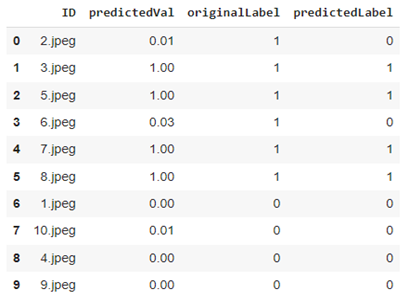

In [ ]:
# Validate in arbitrary set
root_dir = original_dataset_dir + 'arb'
originalLabel = np.array([1,1,1,1,1,0,0,0,0,0])
name_file = 'pretrainedUsedModel_arb'
df = make_prediction(model, val_transform, root_dir,originalLabel,DEVICE,name_file,save=True)
df

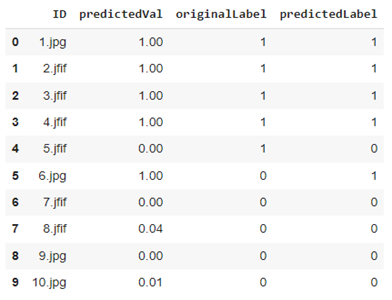

In [ ]:
init_lr = 1e-5
max_lr =  1e-3
num=     10
HyperparameterTuning(init_lr,max_lr,num)